# Simple Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [645]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [646]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [647]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [648]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

front-end_cpu_use  orders_cpu_use  orders-db_cpu_use  user_cpu_use  \
0             0.0300          0.0100             0.0100        0.0100   
1             0.0600          0.0200             0.0200        0.0200   
2             0.0700          0.0300             0.0200        0.0300   
3             0.0700          0.0300             0.0200        0.0200   
4             0.0700          0.0200             0.0100        0.0200   

   user-db_cpu_use  shipping_cpu_use  payment_cpu_use  carts_cpu_use  \
0           0.0100            0.0100           0.0100         0.0300   
1           0.0200            0.0100           0.0100         0.1800   
2           0.0200            0.0100           0.0100         0.4400   
3           0.0200            0.0100           0.0100         0.2300   
4           0.0200            0.0100           0.0100         0.2400   

   carts-db_cpu_use  front-end_pods  orders_pods  user_pods  shipping_pods  \
0            0.0700          1.0000       1.0000     1.0000         1.0000   
1            0.1800          1.0000       1.0000     1.0000         1.0000   
2            0.2000          1.0000       1.0000     1.0000         1.0000   
3            0.1700          1.0000       1.0000     1.0000         1.0000   
4            0.1400          1.0000       1.0000     1.0000         1.0000   

   payment_pods  carts_pods  nodes_cpu_use  orders_req  orders_ltcy  
0        1.0000      1.0000         2.5000      0.1500       0.9311  
1        1.0000      1.0000         1.8900      0.1500       0.9311  
2        1.0000      1.0000         1.3500      0.1500       0.9311  
3        1.0000      1.0000         1.2600      0.1300       0.9311  
4        1.0000      1.0000         1.2800      0.3600       0.9311

In [649]:
data.shape

(3290, 18)

In [650]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 17 features


In [651]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [652]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


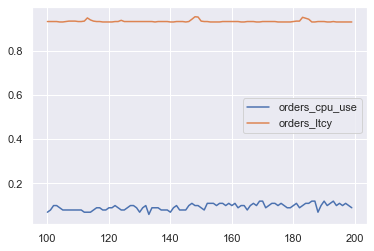

In [653]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [654]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

#sfm = PCA(random_state=180)

reg = LinearRegression(normalize=True) # normalize false bacause we are going to use the scaler

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'selector__estimator__max_depth' : [10, 15]
    , 'selector__estimator__n_estimators' : [20, 30, 40]
    # 'selector__n_components' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]   # with PCA
    , 'reg__normalize': [False, True]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [655]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.4min finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                                                                                        max_leaf_nodes=None,
                                                                                        max_samples=None,
                                                                  

# Best Model

In [656]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
#all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0095:
Best CV params = {'reg__normalize': False, 'selector__estimator__max_depth': 10, 'selector__estimator__n_estimators': 20, 'selector__threshold': '0.02*mean'}


# Features Selected

In [657]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

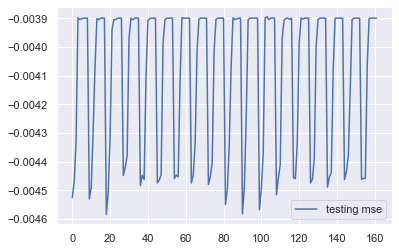

In [658]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [659]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.5153710156158164
Score (training) = -0.00937350972961392


In [660]:
estimator = search.best_estimator_

estimator.named_steps.reg.intercept_

array([0.47563919])

In [661]:
estimator.named_steps.reg.coef_

array([[-0.04250236,  0.05204336,  0.02326738, -0.04681866, -0.01033386,
        -0.01394788,  0.0053514 ,  0.02912956,  0.09649458,  0.13010815,
        -0.03945336, -0.03945336, -0.03945336,  0.03012555, -0.05171672]])

In [662]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.07 (0.07) 0.00 0.62 MSE


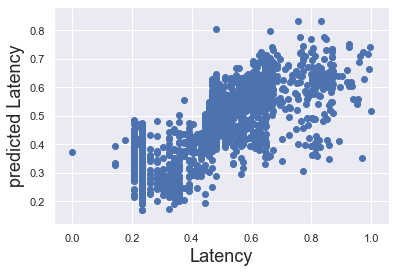

In [663]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

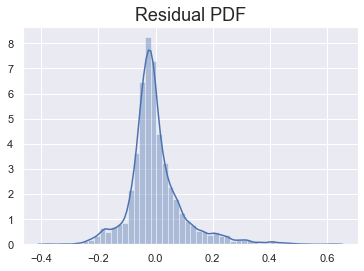

In [664]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [665]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

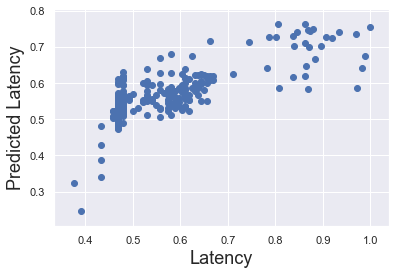

In [666]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

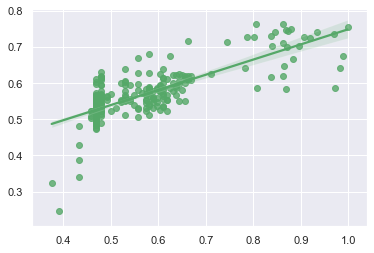

In [667]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [668]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

prediction  target
0      0.5206  0.4689
1      0.5218  0.5013
2      0.5384  0.5482
3      0.5476  0.5210
4      0.5319  0.4801

In [669]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0        0.5206  0.4689    0.0517      11.0202
1        0.5218  0.5013    0.0205       4.0907
2        0.5384  0.5482   -0.0099       1.8005
3        0.5476  0.5210    0.0266       5.1121
4        0.5319  0.4801    0.0518      10.7795
..          ...     ...       ...          ...
324      0.3394  0.4325   -0.0931      21.5351
325      0.2452  0.3908   -0.1455      37.2429
326      0.3879  0.4325   -0.0446      10.3129
327      0.4800  0.4325    0.0475      10.9799
328      0.4293  0.4325   -0.0032       0.7384

[329 rows x 4 columns]

In [670]:
perf.describe()

prediction   target  residual  difference%
count    329.0000 329.0000  329.0000     329.0000
mean       0.5585   0.5461    0.0124      11.3810
std        0.0651   0.1213    0.0814       7.0753
min        0.2452   0.3754   -0.3856       0.5110
25%        0.5211   0.4689   -0.0263       6.6431
50%        0.5472   0.4801    0.0385      10.3129
75%        0.5855   0.5961    0.0614      14.7685
max        0.7638   0.9980    0.1500      39.7039

In [671]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
119        0.58    0.58      0.00         0.51
248        0.57    0.57     -0.00         0.53
20         0.47    0.47      0.00         0.60
303        0.61    0.61      0.00         0.71
328        0.43    0.43     -0.00         0.74
202        0.62    0.61      0.00         0.75
266        0.58    0.58     -0.01         0.94
92         0.59    0.58      0.01         0.94
172        0.57    0.57     -0.01         1.10
236        0.57    0.58     -0.01         1.11
299        0.59    0.58      0.01         1.17
175        0.61    0.62     -0.01         1.21
52         0.47    0.47      0.01         1.27
174        0.59    0.60     -0.01         1.44
169        0.57    0.57      0.01         1.47
226        0.62    0.63     -0.01         1.58
203        0.59    0.60     -0.01         1.58
249        0.60    0.61     -0.01         1.67
31         0.58    0.59     -0.01         1.72
2          0.54    0.55     -0.01         1.80
113        0.58    0.57      0.01         1.92
277        0.49    0.48      0.01         1.99
268        0.55    0.54      0.01         2.04
287        0.58    0.60     -0.01         2.12
205        0.59    0.60     -0.01         2.14
286        0.62    0.64     -0.02         2.44
73         0.48    0.47      0.01         2.94
61         0.56    0.54      0.02         3.00
69         0.48    0.47      0.01         3.01
115        0.62    0.64     -0.02         3.10
142        0.56    0.58     -0.02         3.13
278        0.62    0.60      0.02         3.34
267        0.57    0.55      0.02         3.38
104        0.48    0.47      0.02         3.39
177        0.55    0.57     -0.02         3.49
183        0.49    0.47      0.02         3.60
100        0.49    0.47      0.02         3.64
6          0.55    0.53      0.02         3.67
237        0.55    0.57     -0.02         3.68
238        0.51    0.53     -0.02         3.70
147        0.58    0.60     -0.02         3.95
1          0.52    0.50      0.02         4.09
235        0.58    0.56      0.02         4.11
224        0.53    0.51      0.02         4.11
86         0.59    0.61     -0.03         4.18
103        0.49    0.47      0.02         4.25
255        0.71    0.74     -0.03         4.30
198        0.62    0.65     -0.03         4.33
170        0.58    0.60     -0.03         4.33
58         0.55    0.53      0.02         4.36
107        0.49    0.47      0.02         4.43
120        0.56    0.59     -0.03         4.47
176        0.58    0.60     -0.03         4.52
64         0.53    0.56     -0.03         4.60
16         0.49    0.47      0.02         4.70
273        0.64    0.61      0.03         4.81
63         0.56    0.59     -0.03         4.91
171        0.58    0.61     -0.03         5.01
204        0.60    0.63     -0.03         5.02
46         0.49    0.47      0.02         5.04
262        0.53    0.56     -0.03         5.05
8          0.54    0.57     -0.03         5.09
307        0.76    0.80     -0.04         5.10
3          0.55    0.52      0.03         5.11
108        0.49    0.47      0.03         5.38
13         0.49    0.47      0.03         5.40
144        0.56    0.59     -0.03         5.50
252        0.62    0.66     -0.04         5.55
11         0.50    0.47      0.03         5.66
222        0.55    0.52      0.03         5.82
121        0.56    0.53      0.03         5.85
43         0.50    0.47      0.03         5.91
134        0.50    0.47      0.03         6.00
251        0.60    0.64     -0.04         6.13
149        0.51    0.48      0.03         6.16
201        0.59    0.62     -0.04         6.23
242        0.55    0.52      0.03         6.30
173        0.56    0.60     -0.04         6.40
14         0.50    0.47      0.03         6.43
230        0.62    0.66     -0.04         6.44
234        0.57    0.61     -0.04         6.47
199        0.61    0.66     -0.04         6.47
167        0.50    0.47      0.03         6.64
72         0.50    0.47      0.03         6.65
148       

# *** Prediction Accuracy

In [672]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.5394228685508171


In [673]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.08218845904443345
